## Playground for PDDNet
The class below was taken from the git repo https://github.com/multimodallearning/pdd_net

This is the playgrund for PDD exploration and creating a model, that will be used as a student with FLowNet2 and PWC-Net as teachers

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

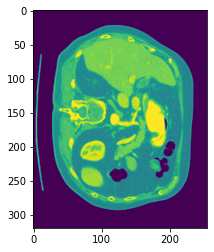

In [4]:
img = torch.load('/home/till/uni/masterArbeit/Tests/img.pth')
seg = torch.load('/home/till/uni/masterArbeit/Tests/seg.pth')
image = img[3:4, :,:]
plt.imshow(image.squeeze())
d,h,w = img.shape

In [5]:
o_m = h//3
o_n = w//3
#o_o = D//3
#print('numel_o',o_m*o_n)
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)

disp_range = 0.4#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)
print(shift_xy.shape)

#_,_,H,W,D = img00.size()
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

torch.Size([1, 1, 225, 2])


/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [6]:
def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

Basically I reduced every dimension as far as I could by 1. This does $\textbf{not}$ mean that this isthe right way to do it. I need to look into the logic behind it

## Obelisk and Deeds 2D 

In [39]:
class OBELISK2d(nn.Module):
    def __init__(self):

        super(OBELISK2d, self).__init__()
        channels = 16
        self.offsets = nn.Parameter(torch.randn(2,channels*2)*0.05)
        self.layer0 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(1)

        self.layer1 = nn.Conv2d(channels*4, channels*4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels*4)
        self.layer2 = nn.Conv2d(channels*4, channels*2, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels*2)
        self.layer3 = nn.Conv2d(channels*2, channels*1, 1)


    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img,3,padding=1,stride=2)
        img_in_l = self.layer0(img_in)
        img_in_b = self.batch0(img_in_l)
        img_in = F.relu(img_in_b)
        #img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in,ogrid_xy + self.offsets[0,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
        sampled -= F.grid_sample(img_in,ogrid_xy + self.offsets[1,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
    
        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


class deeds2d(nn.Module):
    def __init__(self):

        super(deeds2d, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1,.1,1,1,.1,1]))#.cuda()

        self.pad1 = nn.ReplicationPad2d(3)#.cuda()
        self.avg1 = nn.AvgPool2d(3,stride=1)#.cuda()
        self.max1 = nn.MaxPool2d(3,stride=1)#.cuda()
        self.pad2 = nn.ReplicationPad2d(2)#.cuda()##
        
    def forward(self, feat00,feat50):
        
        #deeds correlation layer (slightly unrolled)
        deeds_cost = torch.zeros(1,grid_size**2,displacement_width, displacement_width)

        xy8 = grid_size**2
        for i in range(grid_size): 
            moving_unfold = F.grid_sample(feat50,grid_xy[:,i*xy8:(i+1)*xy8,:,:] + shift_xy,padding_mode='border')
            fixed_grid = F.grid_sample(feat00,grid_xy[:,i*xy8:(i+1)*xy8,:,:])
            deeds_cost[:,i*xy8:(i+1)*xy8,:,:] = self.alpha[1]+self.alpha[0]*torch.sum(torch.pow(fixed_grid-moving_unfold,2),1).view(1,-1,displacement_width,displacement_width)
        
        # remove mean (not really necessary)
        #deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
        deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width)

        # approximate min convolution / displacement compatibility
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))            
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size, grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(1,-1,displacement_width,displacement_width)

        # second path
        cost = self.alpha[4]+self.alpha[2]*deeds_cost+self.alpha[3]*cost_avg
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))
        
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(grid_size**2,displacement_width**2)
        #cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
        #cost = avg1(avg1(-max1(-pad1(cost))))
        
        #probabilistic and continuous output
        cost_soft = F.softmax(-self.alpha[5]*cost_avg,1)
        #pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
        pred_xy = torch.sum(cost_soft.unsqueeze(2)*shift_xy.view(1,-1,2),1)


        return cost_soft,pred_xy

In [40]:
net = OBELISK2d()
reg = deeds2d()
print("overall Params: ", countParameters(net), " + " ,countParameters(reg))

overall Params:  23339  +  6


In [41]:
begin = time.time()
output = net(image.reshape(1,h,w).to(torch.float32))
end = time.time()
print(f"Total runtime of the Obelisk Net is {(end - begin)} for one image \nThat means {25*(end - begin)} for 25 images")
#output.shape

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 5, 5], but got 3-dimensional input of size [1, 160, 128] instead

In [9]:
cost_out, pred = reg(output, output)
print(pred.view(grid_size,grid_size,2).shape)
print(cost_out.shape)

deeds_cost:  torch.Size([1, 1024, 15, 15])
deeds_cost later:  torch.Size([1, 1024, 15, 15])
cost_soft:  torch.Size([1024, 225])
torch.Size([32, 32, 2])
torch.Size([1024, 225])


## Train the network for 2D Input

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,H,W = img_in.size()
    affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B, 2, 3) * strength)#.to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,H,W)))

    img_out = F.grid_sample(img_in.float(), meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float().unsqueeze(1), meshgrid, mode='nearest').long().squeeze(1)

    return img_out, seg_out

In [79]:
torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]
# train_set = pat_indices[:35]
# test_set = torch.cat((pat_indices[35:],torch.LongTensor([17])),0)

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 33, 38, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

print('Test_Set:', test_set)
print('Train_Set:', train_set)

Test_Set: tensor([35, 41,  0,  4, 33, 38, 39, 17])
Train_Set: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 40, 42])


In [80]:
net = OBELISK2d()
net.apply(init_weights)
net.train()

reg = deeds2d()

H, W = img[0].size()

class_weight = torch.sqrt(1.0/(torch.bincount(seg.view(-1)).float()))
class_weight = class_weight/class_weight.mean()
class_weight[0] = 0.15
class_weight[4] /= 10
print('inv sqrt class_weight',class_weight)
criterion = nn.CrossEntropyLoss(class_weight)

epochs = 1000
optimizer = torch.optim.Adam(list(net.parameters())+list(reg.parameters()),lr=0.005)
lambda_weight = 2#2.5#1.5
run_labelloss = torch.zeros(epochs)#/0
run_diffloss = torch.zeros(epochs)

inv sqrt class_weight tensor([0.1500, 0.1535, 0.1800, 0.3199, 0.7610, 0.0681, 0.1290, 0.2074, 0.3098])


<ipython-input-78-03d6183734a7>:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
<ipython-input-78-03d6183734a7>:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.0)


torch.Size([1, 16, 106, 85])
torch.Size([1, 1, 1024, 225])


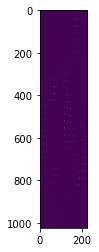

In [84]:
for i in range(epochs):
    
    idx = train_set[torch.randperm(6)].view(2,3)[:,0]
    
    optimizer.zero_grad()

    label_moving = torch.zeros(size=(1,9,H,W))
    label_moving = label_moving.scatter_(1, seg[idx[1]:idx[1]+1,:,:].type(torch.int64).unsqueeze(1), 1)

    img00_in = img[idx[0]:idx[0]+1,:,:].unsqueeze(0).float() // 255
    img50 = img[idx[1]:idx[1]+1,:,:].unsqueeze(0).float() // 255

    img00, seg50 = augmentAffine(img00_in,seg[idx[0]:idx[0]+1,:,:],0.0375)
    img00.requires_grad = True
    img50.requires_grad = True

    label_fixed = torch.zeros(size=(1,9,H,W))
    label_fixed = label_fixed.scatter_(1, seg50.unsqueeze(1), 1)

    # get features (regular grid)
    feat00 = net(img00)#checkpoint(net,img00)#net(img00)# #00 is fixed
    feat50 = net(img50)#checkpoint(net,img50)#net(img50)# #50 is moving
    # run differentiable deeds (regular grid)
    cost_soft,pred_xy =  reg(feat00,feat50)#checkpoint(reg,feat00,feat50)#reg(feat00,feat50)#
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    # evaluate diffusion regularisation loss
    
    diffloss = lambda_weight*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            lambda_weight*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            lambda_weight*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    run_diffloss[i] = diffloss.item()


    # evaluate non-local loss
    tmp = (F.grid_sample(label_moving,grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,grid_size**2,displacement_width**2))
    nonlocal_label = (F.grid_sample(label_moving,grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(label_fixed,grid_xy,padding_mode='border')#.long().squeeze(1)
    print(nonlocal_label.shape)
    plt.imshow(nonlocal_label.detach().numpy().squeeze())
    
    labelloss = ((nonlocal_label-fixed_label)**2)*class_weight.view(1,-1,1,1)
    labelloss = labelloss.mean()
    #labelloss = criterion(nonlocal_label,fixed_label)
    run_labelloss[i] = labelloss.item()
    #(labelloss+diffloss).backward()

    #optimizer.step()
    break
    if(i%50==49):

        loss_avg = F.avg_pool1d(run_labelloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_labelloss',loss_avg[-1])
        loss_avg = F.avg_pool1d(run_diffloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_diffloss',loss_avg[-1])

In [19]:
random_test = test_set[torch.randperm(6)].view(2,3)[:,0]
test_img_1 = img[random_test[0]:random_test[0]+1,:,:].unsqueeze(0).float() // 255
test_img_2 = img[random_test[1]:random_test[1]+1,:,:].unsqueeze(0).float() // 255

label_1= seg[random_test[0]:random_test[0]+1,:,:]
label_2= seg[random_test[1]:random_test[1]+1,:,:]


In [22]:
fixed = net(test_img_1)
moving = net(test_img_2)

test_cost_xy, test_pred_xy = reg(fixed,moving) 

In [23]:
test_pred_xy = test_pred_xy.view(1,grid_size,grid_size,2)

In [33]:
test_pred_xy.squeeze().shape

torch.Size([32, 32, 2])

In [26]:
from utils.plotting import *

In [35]:
flow = showFlow(test_pred_xy.squeeze().detach())
flow.shape

(32, 2, 3)